範例說明大部份參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/random_walk.py)

TD與MC很大的差異在於，MC需要在一個episode結束的時候才能計算相關的value function，但是TD只需要過一個time step就可以計算，不過這有很大的差異在裡面，因為TD估測的已經不是expected return，而是$R_{t+1} + \gamma V(S_{t+1})$(for TD(0))


這個範例中，我們會憑經驗來比較TD(0)與constant-$\alpha$ MC的預測能力，用下面這個Markov reward process：
![](https://i.imgur.com/7RgWEIz.png)

Markov reward process，或稱MRP，它是一種Markov decision process沒有action的變體。當我們關注的是預測問題(prediction problem)的時候，我們通常會使用MRPs，這樣我們就不需要去區分這個變動是因為環境，還是來自agent。這個MRP的範例中，所有的episodes都是從中間這個state，也就是$C$開始，然後每個step就是等機率的往左、往右跳一個state。只要到達最左邊或是最右邊的時候，當下的episode就算結束。如果是到最左邊，那reward +0，如果是最右邊，那reward +1。這邊給出一個可能的例子：$C,0,B,0,C,0,D,0,E,1$。因為這個task是undiscounted，所以每個state的實際值(true value)就會是從該state開始會結束於最右邊的機率。所以啊，我們就可以知道中間那一個state的true value就是$v_\pi(C)=0.5$。這樣就不難明白，$A\sim E$的true value則是$\dfrac{1}{6},\dfrac{2}{6},\dfrac{3}{6},\dfrac{4}{6},\dfrac{5}{6}$

![](https://i.imgur.com/Buk2QWv.png)

上圖左說明了不同episodes各state在做TD(0)後的學習結果。可以看的到在100個episodes之後得到的值已經非常接近實際值，這邊的constant step-size，$\alpha$設置為0.1，因此估測值的波動所反應的是比較接近的episodes。右圖所顯示的則是兩個方法在不同的$\alpha$下的學習曲線。效能的量測是採取學習到的value function與實際的value function之間的RMS(root mean square)，每5個state計算平均，然後在這100次執行中計算平均。然後對於所有的$s$，其approximate value function都被初始化為中間值，$V(s)=0.5$。這個任務來看，TD的表現比MC還要來的好。

首先載入需求套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

根據說明，我們會有A、B、C、D、E這五個state再加上A的左邊跟E的右邊兩個terminal state，總共7個state，每個state都有它的true value

In [2]:
TRUE_VALUE = np.ones(7)
TRUE_VALUE[0] = 0
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

每個state的value都初始化為0.5，然後我們會把右邊那個terminal state的預設值設置為1，這計算過程中是有幫助的

In [3]:
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
VALUES[6] = 1
VALUES

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. ])

這個範例的狀態轉移很簡單，不是向左就是向右

In [4]:
TRANSITION_LEFT = 0
TRANSITION_RIGHT = 1

In [5]:
# 左右的機率各半
probs = [0.5, 0.5]
np.random.choice([TRANSITION_LEFT, TRANSITION_RIGHT], p=probs)

0

過程中的reward皆為0，然後只有進到最右邊的terminal state才會得到reward+1

下面給出公式6.1做為參考  
$$V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)] \tag{6.1}$$

先來看看Monte Carlo

In [6]:
def monte_carlo(values, alpha=0.1):
    # 所有的state都是從3開始
    state = 3
    trajectory = [3]
    
    while True:
        # 狀態的轉機轉移
        if np.random.choice([TRANSITION_LEFT, TRANSITION_RIGHT], p=probs) == TRANSITION_LEFT:
            state -= 1
        else:
            state += 1
        # 寫入軌跡記錄
        trajectory.append(state)
        # 判斷是否結束
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break
            
    
    # 計算每個state的value
    for _state in trajectory[: -1]:
        values[_state] += alpha * (returns - values[_state])
        
    return trajectory, [returns] * (len(trajectory) - 1)

In [15]:
_values = np.copy(VALUES)
trajectory, abc = monte_carlo(_values)

In [17]:
trajectory, abc

([3, 4, 5, 6], [1.0, 1.0, 1.0])

接下來是TD，下面給出公式6.2參考  
$$V(S_t) \leftarrow V(S_t) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)] \tag{6.2}$$

In [7]:
def temporal_difference(values, alpha=0.1):
    # 所有的state都是從3開始
    state = 3
    trajectory = [3]
    rewards = [0]
    
    while True:
        old_state = state
        if np.random.choice([TRANSITION_LEFT, TRANSITION_RIGHT], p=probs) == TRANSITION_LEFT:
            state -= 1
        else:
            state += 1
        
        # 這邊每一個state的變化得到的reward皆為0
        # 跟上面設置的VALUES有關，算是一種小技巧吧，我猜        
        reward = 0
        
        trajectory.append(state)
        # 根據公式計算value
        values[old_state] += alpha * (reward + values[state] - values[old_state])
        
        if state == 6 or state == 0:
            break
        
        rewards.append(reward)
    
    return trajectory, rewards

下次設置一個函數要來執行各自為0、1、10、100個episodes

In [8]:
def compute_state_value():
    """計算state value"""
    episodes = [0, 1, 10, 100]
    current_values = np.copy(VALUES)
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(current_values, label=str(i)+' episodes')
#         print(current_values)
        temporal_difference(current_values)
    plt.plot(TRUE_VALUE, label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()

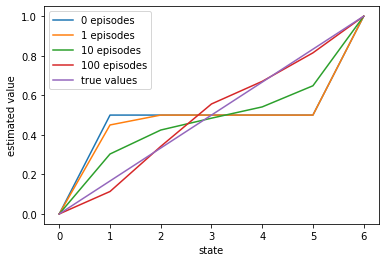

In [9]:
compute_state_value()

上面的圖你只要切頭去尾就會長的很像書本上的圖了

接下來我們試著計算RMS

In [10]:
def rms_error():
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        
        # 根據條件設置圖表
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        
        for r in tqdm(range(runs)):
            errors = []
            current_values = np.copy(VALUES)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                if method == 'TD':
                    temporal_difference(current_values, alpha=alpha)
                else:
                    monte_carlo(current_values, alpha=alpha)
                
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', lpha= %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()
    

100%|██████████| 100/100 [00:02<00:00, 48.06it/s]


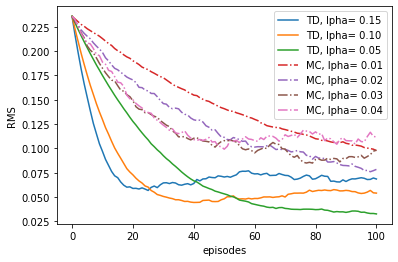

In [11]:
rms_error()